In [14]:
%matplotlib inline
import os
import numpy as np
from astropy.cosmology import Planck15 as cosmo
from astrotog import functions as afunc
from astrotog import classes as aclasses
from astrotog import top_level_classes as atopclass
from itertools import repeat
import datetime
import time
from copy import copy, deepcopy
import pandas as pd
from scipy.integrate import simps
import warnings
import sncosmo
from matplotlib import pyplot as plt
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
# Set seed for reproduceability
np.random.seed(12345)

In [16]:
check_transient= atopclass.rosswog_kilonova(mej=0.01,vej=0.05,kappa=1.0)
check_transient2= atopclass.rosswog_numerical_kilonova('/Users/cnsetzer/Documents/LSST/kilonova_seds/rosswog/NSNS/winds/SED_wind1.dat', singleSED=True)
check_transient3= atopclass.rosswog_numerical_kilonova('/Users/cnsetzer/Documents/LSST/pintoeastman_macronovae/RUN/mne-SED.dat', singleSED=True)
#check_transient4= atopclass.scolnic_kilonova('/Users/cnsetzer/Documents/LSST/kilonova_seds/scolnic/DECAMGemini_SED.txt')

phase, wave, flux = sncosmo.read_griddata_ascii('/Users/cnsetzer/Documents/LSST/kilonova_seds/rosswog/NSNS/winds/SED_wind1.dat')
source = sncosmo.TimeSeriesSource(phase=phase, wave=wave, flux=flux)
check_transient5 = sncosmo.Model(source)
check_transient5.phase = phase 
check_transient5.wave = wave
check_transient5.flux = flux

In [18]:
plot_flux = []
for i in range(len(check_transient.phase)):
    plot_flux.append(simps(check_transient.flux[i],check_transient.wave))
plot_flux2 = []
for i in range(len(check_transient2.phase)):
    plot_flux2.append(simps(check_transient2.flux[i],check_transient2.wave))
plot_flux3 = []
for i in range(len(check_transient3.phase)):
    plot_flux3.append(simps(check_transient3.flux[i],check_transient3.wave))
#plot_flux4 = []
#for i in range(len(check_transient4.phase)):
#    plot_flux4.append(simps(check_transient4.flux[i],check_transient4.wave))
plot_flux5 = []
for i in range(len(check_transient5.phase)):
    plot_flux5.append(simps(check_transient5.flux[i],check_transient5.wave))

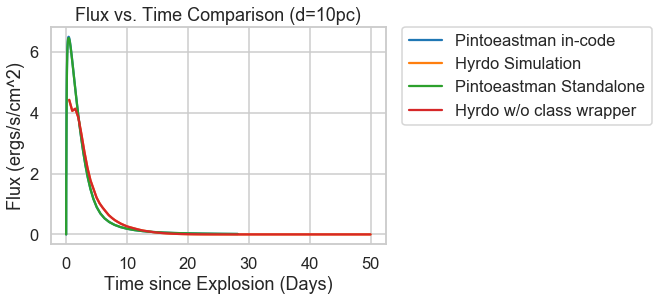

In [19]:
plt.plot(check_transient.phase, plot_flux)
plt.plot(check_transient2.phase, plot_flux2)
plt.plot(check_transient3.phase, plot_flux3)
#plt.plot(check_transient4.phase, plot_flux4)
plt.plot(check_transient5.phase, plot_flux5)
plt.legend(['Pintoeastman in-code','Hyrdo Simulation','Pintoeastman Standalone', 'Hyrdo w/o class wrapper'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Flux vs. Time Comparison (d=10pc)')
plt.xlabel('Time since Explosion (Days)')
plt.ylabel('Flux (ergs/s/cm^2)')
plt.show()

## Now compare other SEDS

### Comparing the flux vs. time

In [52]:
def compare_macronovae(which='winds',name ='wind1',DZ_factor=1.0, thermalization=0.25, exponent=1.3, early_day=1.0, late_day=20.0):
    
    Hydro_SEDs= atopclass.rosswog_numerical_kilonova('/Users/cnsetzer/Documents/LSST/kilonova_seds/rosswog/NSNS/{0}/SED_{1}.dat'.format(which,name), singleSED=True)
    print('The parameters are eject mass: {0}, ejecta velocity: {1}, effective opacity: {2}'.format(Hydro_SEDs.param1,Hydro_SEDs.param2,Hydro_SEDs.param3))
    parameters = []
    parameters.append(0.00001157) # start time (days)
    parameters.append(50.0) # end time of integration (days)
    parameters.append(Hydro_SEDs.param1) # ejecta mass
    parameters.append(Hydro_SEDs.param2) # ejecta velocity
    parameters.append(exponent) # exponent nuclear heating rate
    parameters.append(thermalization) # thermalization factor
    parameters.append(DZ_factor)  # DZ31 factor
    parameters.append(Hydro_SEDs.param3) # effective opacity
    parameters.append(150.0) # starting temperature
    parameters.append(False) # Boolean to read heating rates file
    parameters.append('dummy string') # heating rates file string

    PE_SEDs = atopclass.rosswog_kilonova(KNE_parameters=parameters)
    
    plot_flux = []
    for i in range(len(PE_SEDs.phase)):
        plot_flux.append(simps(PE_SEDs.flux[i],PE_SEDs.wave))
    plot_flux2 = []
    for i in range(len(Hydro_SEDs.phase)):
        plot_flux2.append(simps(Hydro_SEDs.flux[i],Hydro_SEDs.wave))
    
    comparison_fig = plt.figure()
    plt.plot(PE_SEDs.phase, plot_flux)
    plt.plot(Hydro_SEDs.phase, plot_flux2)
    plt.legend(['Pintoeastman in-code','Hyrdo Simulation'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Flux vs. Time Comparison (d=10pc) {0}'.format(name))
    plt.xlabel('Time since Explosion (Days)')
    plt.ylabel('Flux (ergs/s/cm^2)')
    plt.xlim([-0.2,20])
    
    #first sed figure
    
    mindex1 = (np.abs(PE_SEDs.phase - early_day)).argmin()
    mindex2 = (np.abs(Hydro_SEDs.phase - early_day)).argmin()
    early_sed_fig = plt.figure()
    plt.plot(PE_SEDs.wave,PE_SEDs.flux[mindex1])
    plt.plot(Hydro_SEDs.wave, Hydro_SEDs.flux[mindex2])
    plt.legend(['Pintoeastman in-code','Hyrdo Simulation'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('SED Comparison (d=10pc) {0} days'.format(early_day))
    plt.xlabel('Wavelengths (Angs)')
    plt.ylabel('Flux (ergs/s/cm^2/Ang)')
    
        #first sed figure
    
    mindex1 = (np.abs(PE_SEDs.phase - late_day)).argmin()
    mindex2 = (np.abs(Hydro_SEDs.phase - late_day)).argmin()
    late_sed_fig = plt.figure()
    plt.plot(PE_SEDs.wave,PE_SEDs.flux[mindex1])
    plt.plot(Hydro_SEDs.wave, Hydro_SEDs.flux[mindex2])
    plt.legend(['Pintoeastman in-code','Hyrdo Simulation'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('SED Comparison (d=10pc) {0} days'.format(late_day))
    plt.xlabel('Wavelengths (Angs)')
    plt.ylabel('Flux (ergs/s/cm^2/Ang)')
    
    return comparison_fig, early_sed_fig, late_sed_fig

The parameters are eject mass: 0.01, ejecta velocity: 0.05, effective opacity: 1.0


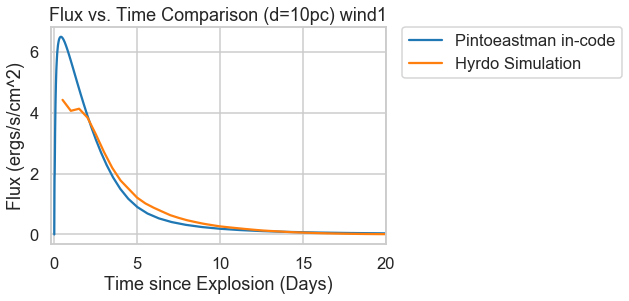

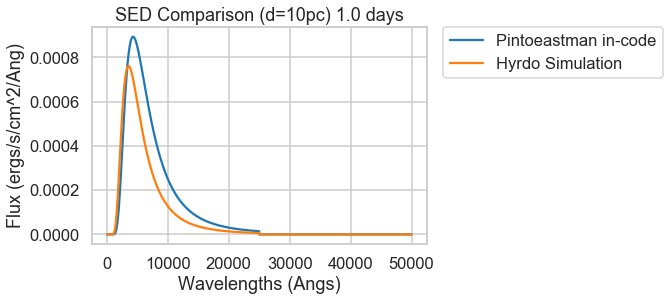

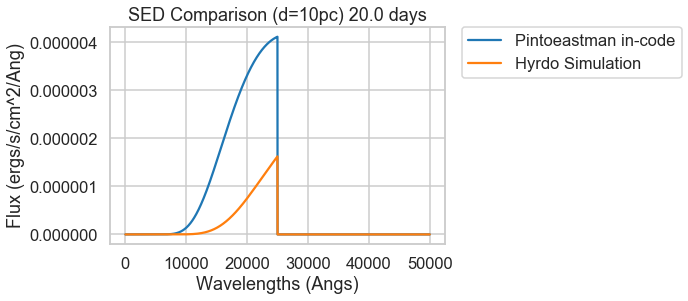

In [53]:
fig1, fig2, fig3 = compare_macronovae(which='winds',name='wind1')
plt.show(fig1)
plt.show(fig2)
plt.show(fig3)